# Hatfield timelapse ERT

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
 # trick to import a resipy from a local copy (you won't need that if you `pip install resipy`)
import sys 
sys.path.append('../src')

from resipy import R2
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv

datadir = '../src/examples/dc-3d-timelapse-bh/'

API path =  /media/jkl/data/phd/tmp/resipy/src/resipy
ResIPy version =  2.2.3
cR2.exe found and up to date.
R3t.exe found and up to date.
cR3t.exe found and up to date.


In [3]:
k = R2(typ='R3t')
k.createTimeLapseSurvey(datadir + 'data/', ftype='ProtocolDC')
k.surveys = k.surveys[:3]
k.importElec(datadir + 'elec.csv')

Working directory is: /media/jkl/data/phd/tmp/resipy/src/resipy
clearing dirname
9/9 imported


divide by zero encountered in true_divide


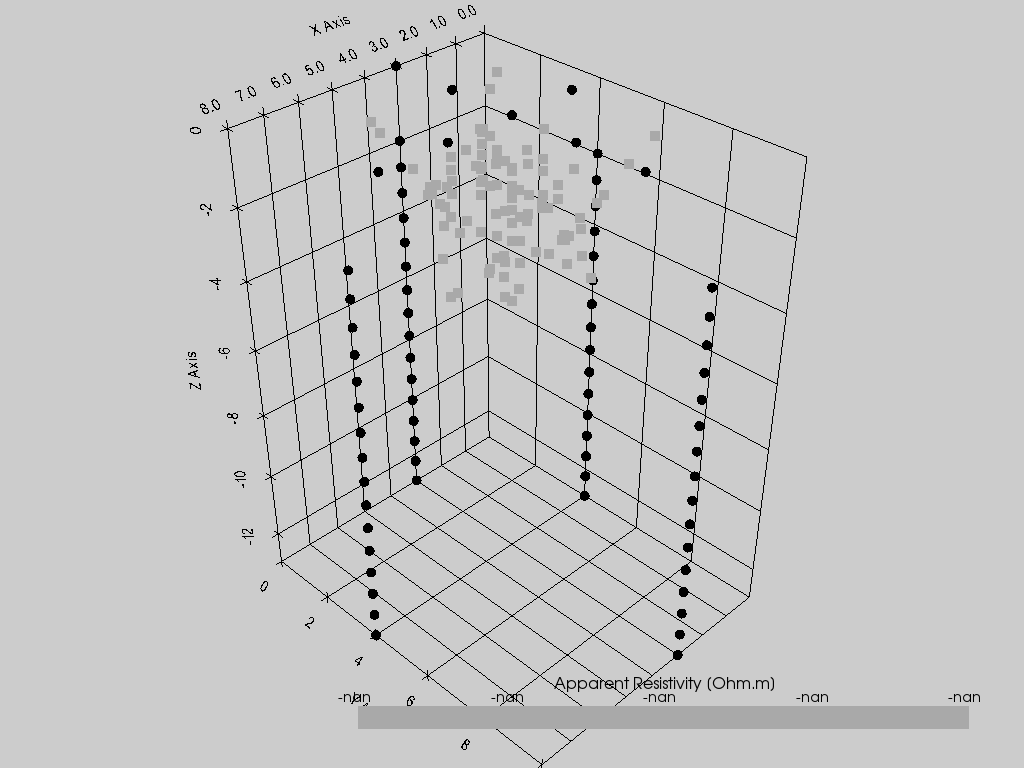

In [4]:
# the 3D pseudo-section is meaningless in this case as it's not a simple set of 2D lines
pl = pv.Plotter()
k.showPseudo(ax=pl, threed=True)

Creating tetrahedral mesh...found buried electrodes
fmd in gmshWrap.py: 15.733537
writing .geo to file completed, save location:
/media/jkl/data/phd/tmp/resipy/src/resipy/invdir

Reading mesh3d.msh
Gmsh version == 3.x
reading node coordinates...
Determining element type...Tetrahedra
Reading connection matrix...
ignoring 234 elements in the mesh file, as they are not required for R2/R3t
Finished reading .msh file
interpolating topography onto mesh using triangulate interpolation...done
Done
ResIPy Estimated RAM usage = 0.070403 Gb
done


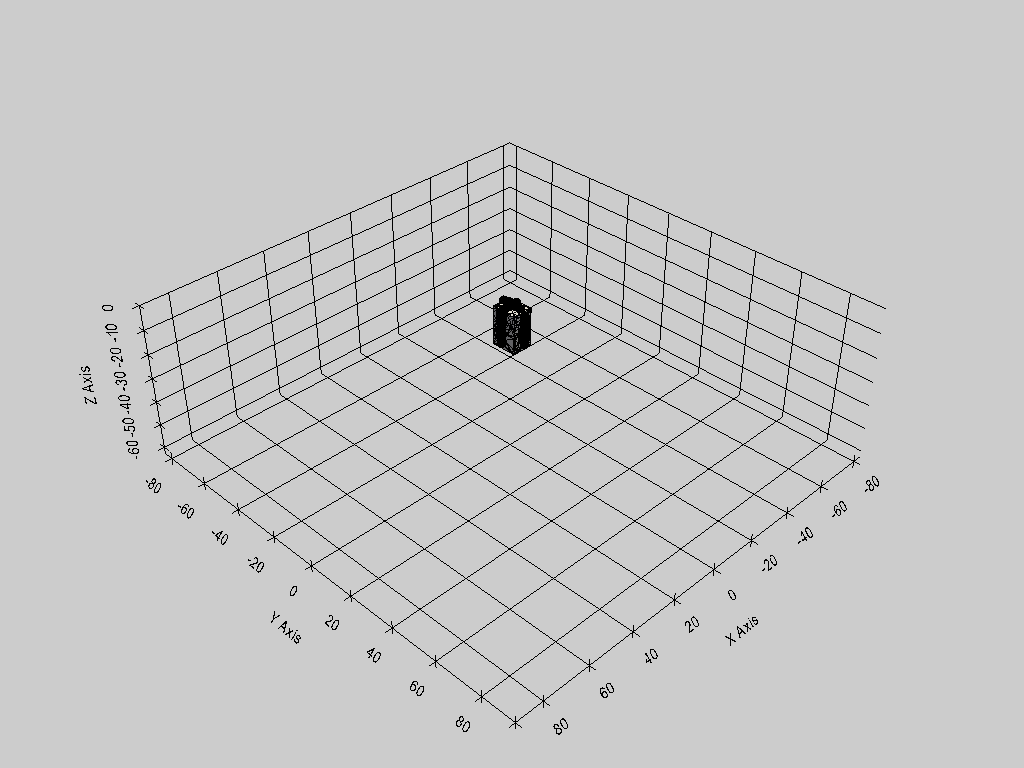

In [5]:
k.createMesh(cl=10)
pl = pv.Plotter()
k.showMesh(ax=pl, zlim=[-15, 0])

In [6]:
k.param['num_xy_poly'] = 0
k.param['zmin'] = -10e10
k.param['b_wgt'] = 0.05
k.param['reg_mode'] = 1 # background regularization
k.invert(parallel=True)

Writing .in file and protocol.dat... done!
------------ INVERTING REFERENCE SURVEY ---------------


 >> R 3 t     E R T    M o d e l    v2.01 <<

 >> Date: 30-08-2020
 >> My beautiful 3D survey                                                          
 >> I n v e r s e   S o l u t i o n   S e l e c t e d <<
 >> T e t r a h e d r a l   E l e m e n t   M e s h <<

 >> Reading mesh file 
 >> Determining storage needed for finite element conductance matrix
 >> Generating index array for finite element conductance matrix
 >> Reading resistivity model from res0.dat                                                                        

 >> L o g - D a t a   I n v e r s i o n <<
 >> N o r m a l   R e g u l a r i s a t i o n <<

 >> Memory estimates:
    For   1000 measurements the memory needed is:          0.023 Gb
    For   2000 measurements the memory needed is:          0.046 Gb
    For   5000 measurements the memory needed is:          0.113 Gb
    For  10000 measurements the memory ne

NOTES:
- no difference(percent) attribute available (not computed by R3t) as difference inversion is not available
- need reg_mode = 1 then!
- but k.computeDiff() doesn't work too .... maybe TODO

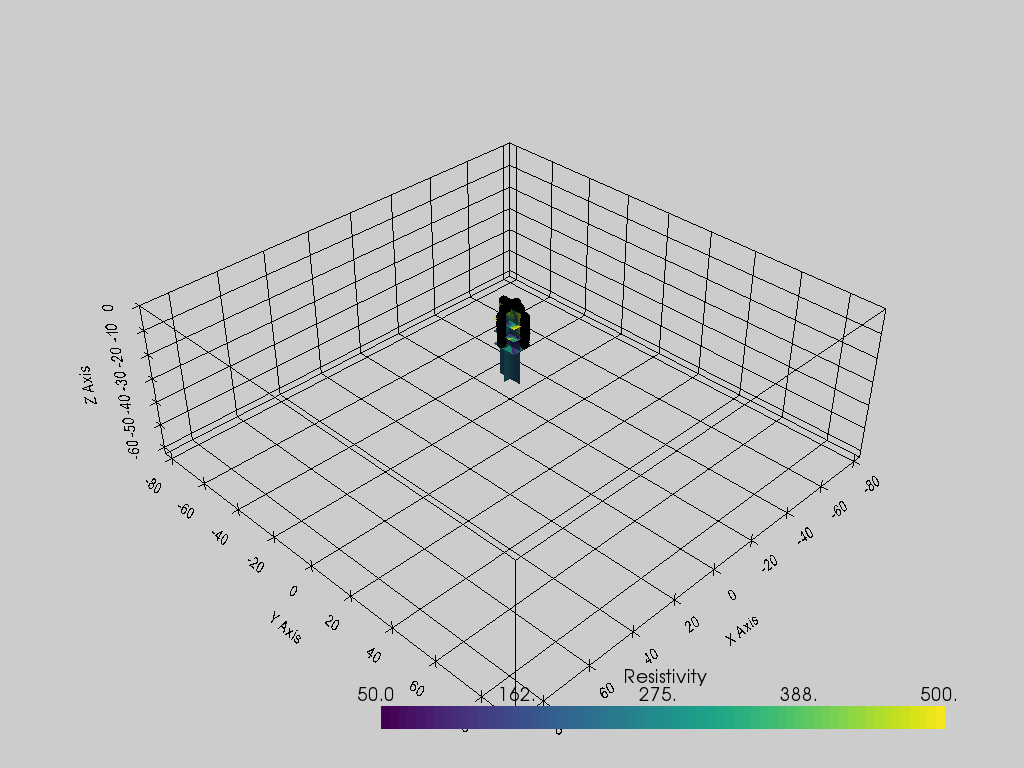

In [7]:
pl = pv.Plotter()
k.showResults(ax=pl, attr='Resistivity', index=0, 
              zlim=[-20, 0], pvslices=[[5],[5],[-5, -10, -15]], vmin=50, vmax=500)

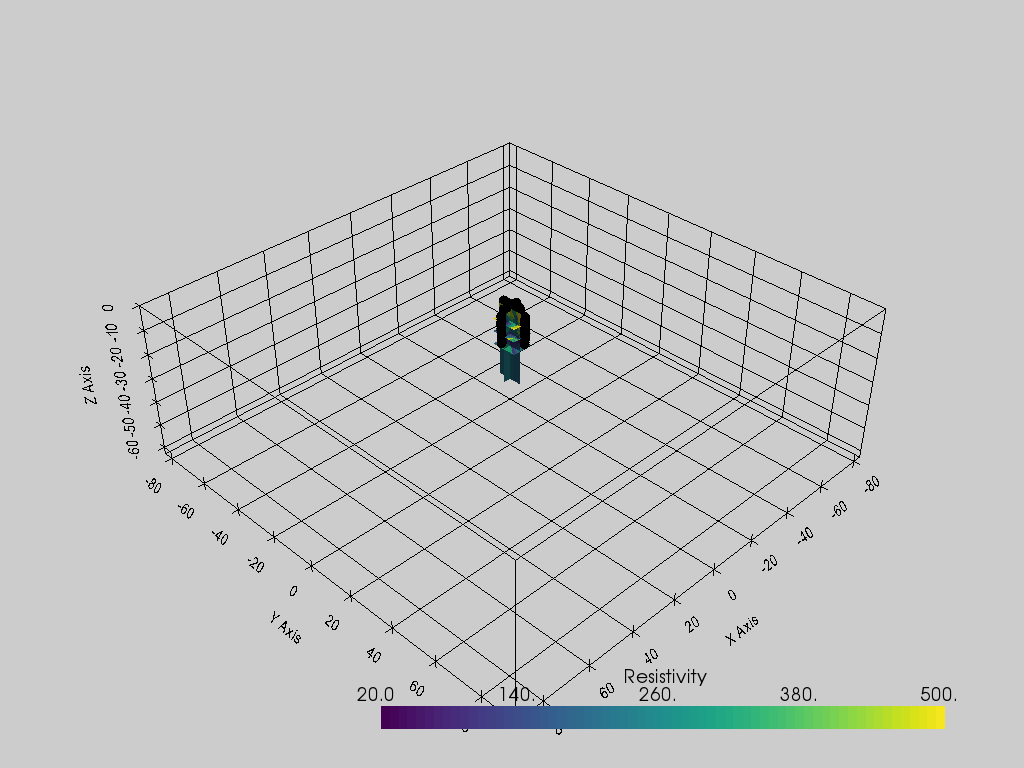

In [8]:
pl = pv.Plotter()
k.showResults(ax=pl, attr='Resistivity', index=1, 
              zlim=[-15, 0], pvslices=[[5],[5],[-5, -10, -15]], vmin=20, vmax=500)
# zlim doesn't seem to work :/

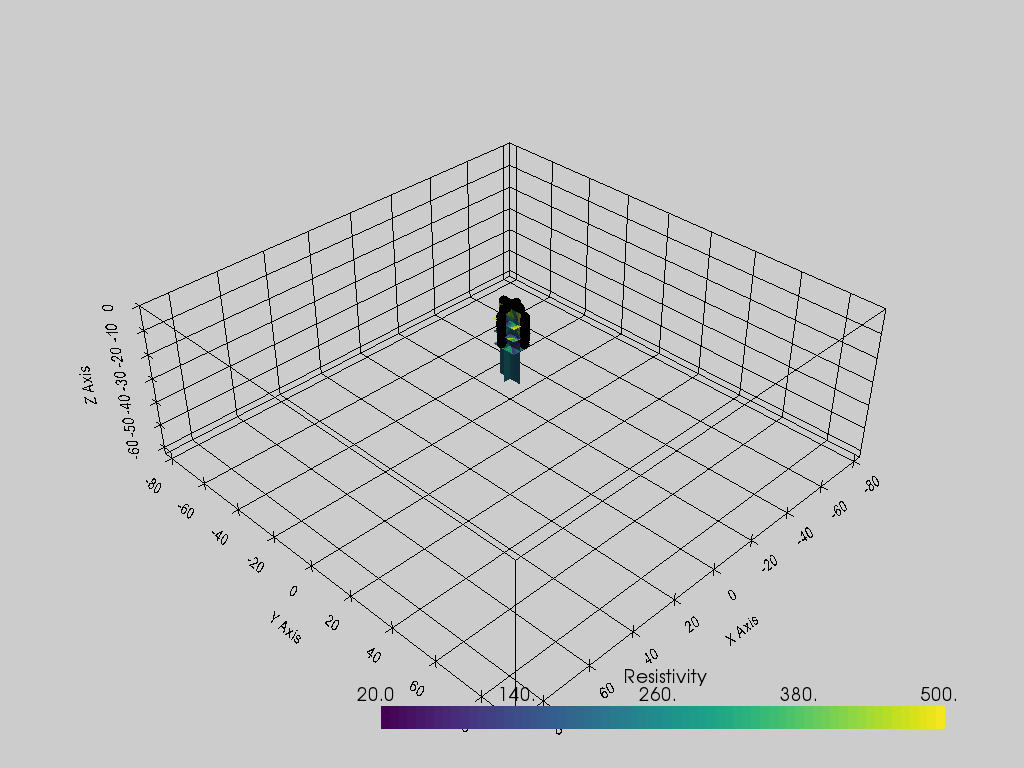

In [9]:
pl = pv.Plotter()
k.showResults(ax=pl, attr='Resistivity', index=2, 
              zlim=[-15, 0], pvslices=[[5],[5],[-5, -10, -15]], vmin=20, vmax=500)
# zlim doesn't seem to work :/

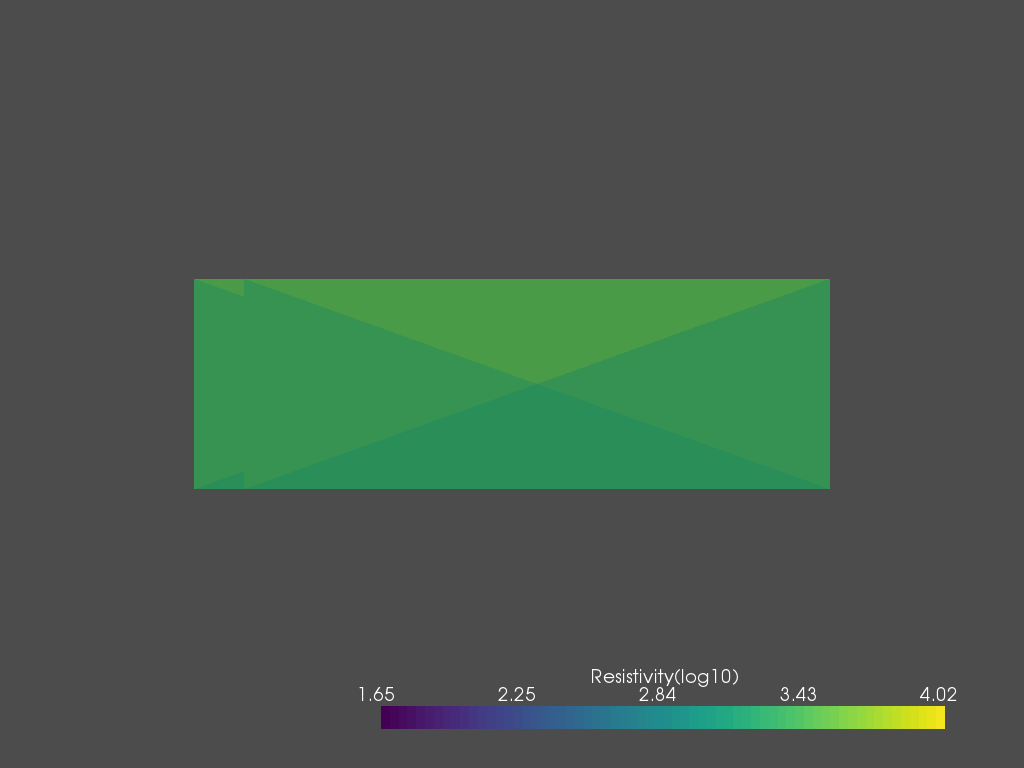

In [10]:
# graph
wd = k.dirname + '/'
a = 15
p = pv.Plotter(notebook=True)
for i in range(2):
    mesh = pv.read(wd + 'f{:03d}_res.vtk'.format(i+1))
    mesh.translate([a*i, 0, 0])
    p.add_mesh(mesh, scalars='Resistivity(log10)', cmap='viridis')
    melec = pv.PolyData(k.elec[['x','y','z']].values)
    melec.translate([a*i, 0, 0])
    p.add_mesh(melec)
p.view_xz()
p.show()
# add annotation